In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import os
from scipy.io import wavfile
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from glob import glob
import argparse
import warnings
from tensorflow.keras import layers
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D
import matplotlib.pyplot as plt

In [2]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, wav_paths, labels, sr, dt, n_classes,
                 batch_size=32, shuffle=True):
        self.wav_paths = wav_paths
        self.labels = labels
        self.sr = sr
        self.dt = dt
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.shuffle = True
        self.on_epoch_end()


    def __len__(self):
        return int(np.floor(len(self.wav_paths) / self.batch_size))


    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        wav_paths = [self.wav_paths[k] for k in indexes]
        labels = [self.labels[k] for k in indexes]

        # generate a batch of time data
        X = np.empty((self.batch_size, 1, int(self.sr*self.dt)), dtype=np.float32)
        Y = np.empty((self.batch_size, self.n_classes), dtype=np.float32)

        for i, (path, label) in enumerate(zip(wav_paths, labels)):
            rate, wav = wavfile.read(path)
            X[i,] = wav.reshape(1, -1)
            Y[i,] = to_categorical(label, num_classes=self.n_classes)

        return X, Y


    def on_epoch_end(self):
        self.indexes = np.arange(len(self.wav_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [3]:
src_root = 'Archivos_procesados'
sr = 16000
dt = 2.0
batch_size = 5
model_type = 'conv1d'

In [4]:
wav_paths = glob('{}/**'.format(src_root), recursive=True)  

In [5]:
wav_paths = [x.replace(os.sep, '/') for x in wav_paths if '.wav' in x] 

In [6]:
classes = sorted(os.listdir(src_root)) 
classes

['Charo', 'Gonza']

In [7]:
le = LabelEncoder() 

In [8]:
le.fit(classes)

LabelEncoder()

In [9]:
labels = [os.path.split(x)[0].split('/')[-1] for x in wav_paths]  
#labels

In [10]:
labels = le.transform(labels) 

In [11]:
wav_train, wav_val, label_train, label_val = train_test_split(wav_paths,
                                                                  labels,
                                                                  test_size=0.1,
                                                                  random_state=0)

In [12]:
tg = DataGenerator(wav_train, label_train, sr, dt, 2, batch_size=batch_size)  

In [13]:
vg = DataGenerator(wav_val, label_val, sr, dt, 2, batch_size=batch_size)

In [14]:
i = layers.Input(shape=(1, int(sr*dt)), name='input')  #Shape (1,32000), Nombre 
x = Melspectrogram(n_dft=512, n_hop=160,padding='same', sr=sr, n_mels=128,fmin=0.0, fmax=sr/2, power_melgram=2.0,return_decibel_melgram=True, trainable_fb=False,
                       trainable_kernel=False, name='melbands')(i)
x = Normalization2D(str_axis='batch', name='batch_norm')(x)
x = layers.Permute((2,1,3), name='permute')(x)
x = TimeDistributed(layers.Conv1D(8, kernel_size=(4), activation='tanh'), name='td_conv_1d_tanh')(x)
x = layers.MaxPooling2D(pool_size=(2,2), name='max_pool_2d_1')(x)
x = TimeDistributed(layers.Conv1D(16, kernel_size=(4), activation='relu'), name='td_conv_1d_relu_1')(x)
x = layers.MaxPooling2D(pool_size=(2,2), name='max_pool_2d_2')(x)
x = TimeDistributed(layers.Conv1D(32, kernel_size=(4), activation='relu'), name='td_conv_1d_relu_2')(x)
x = layers.MaxPooling2D(pool_size=(2,2), name='max_pool_2d_3')(x)
x = TimeDistributed(layers.Conv1D(64, kernel_size=(4), activation='relu'), name='td_conv_1d_relu_3')(x)
x = layers.MaxPooling2D(pool_size=(2,2), name='max_pool_2d_4')(x)
x = TimeDistributed(layers.Conv1D(128, kernel_size=(4), activation='relu'), name='td_conv_1d_relu_4')(x)
x = layers.GlobalMaxPooling2D(name='global_max_pooling_2d')(x)
x = layers.Dropout(rate=0.1, name='dropout')(x)
x = layers.Dense(64, activation='relu', activity_regularizer=l2(0.001), name='dense')(x)
o = layers.Dense(2, activation='sigmoid', name='sigmoid')(x)  #N_CLASSES

model = Model(inputs=i, outputs=o, name='1d_convolution')
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy']) #binary_accuracy

c:\users\gonza\.conda\envs\audio\lib\site-packages\librosa\filters.py:196: FutureWarning: norm=1 behavior will change in librosa 0.8.0. To maintain forward compatibility, use norm='slaney' instead.
  FutureWarning)


In [15]:
model.summary()

Model: "1d_convolution"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1, 32000)]        0         
_________________________________________________________________
melbands (Melspectrogram)    (None, 128, 200, 1)       296064    
_________________________________________________________________
batch_norm (Normalization2D) (None, 128, 200, 1)       0         
_________________________________________________________________
permute (Permute)            (None, 200, 128, 1)       0         
_________________________________________________________________
td_conv_1d_tanh (TimeDistrib (None, 200, 125, 8)       40        
_________________________________________________________________
max_pool_2d_1 (MaxPooling2D) (None, 100, 62, 8)        0         
_________________________________________________________________
td_conv_1d_relu_1 (TimeDistr (None, 100, 59, 16)    

In [17]:
history = model.fit(tg, validation_data=vg,
              epochs=5, verbose=2, workers=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 32 steps, validate for 3 steps
Epoch 1/5
32/32 - 2s - loss: 0.6753 - accuracy: 0.6375 - val_loss: 0.6353 - val_accuracy: 0.8000
Epoch 2/5
32/32 - 1s - loss: 0.3145 - accuracy: 0.9500 - val_loss: 0.0698 - val_accuracy: 1.0000
Epoch 3/5
32/32 - 1s - loss: 0.0623 - accuracy: 1.0000 - val_loss: 0.0523 - val_accuracy: 1.0000
Epoch 4/5
32/32 - 1s - loss: 0.0449 - accuracy: 1.0000 - val_loss: 0.0390 - val_accuracy: 1.0000
Epoch 5/5
32/32 - 1s - loss: 0.0371 - accuracy: 1.0000 - val_loss: 0.0341 - val_accuracy: 1.0000


In [18]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

In [19]:
epochs   = range(len(acc)) 

<Figure size 432x288 with 0 Axes>

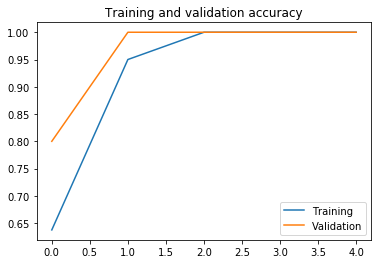

<Figure size 432x288 with 0 Axes>

In [20]:
plt.plot  ( epochs,     acc, label = 'Training' )
plt.plot  ( epochs, val_acc, label = 'Validation' )
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

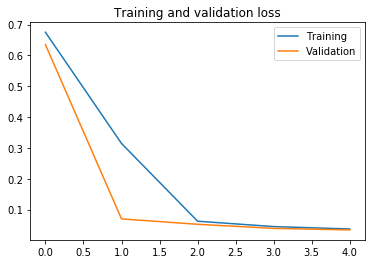

In [21]:
plt.plot  ( epochs,     loss ,label = 'Training')
plt.plot  ( epochs, val_loss ,label = 'Validation')
plt.title ('Training and validation loss'   )
plt.legend()

In [22]:
wav_ruta = glob('{}/**'.format('Archivos_procesados_test'), recursive=True)
wav_ruta = [x for x in wav_ruta if '.wav' in x]

In [24]:
for i in wav_ruta:
    rate_predict, wav_predict = wavfile.read(i)
    wav_predict = wav_predict.reshape(1,1,-1)
    prediccion = model.predict(wav_predict)
    if prediccion[0][0] < prediccion [0][1]:
        print('La prediccion para' + i + 'es: Gonza')
    elif prediccion[0][0] > prediccion[0][1]:
        print('La prediccion para' + i + 'es: Charo')
    else:
        print('La prediccion no puede hacerse')
            
        

La prediccion paraArchivos_procesados_test\Charo\Charo_0.waves: Charo
La prediccion paraArchivos_procesados_test\Charo\Charo_1.waves: Charo
La prediccion paraArchivos_procesados_test\Charo\Charo_10.waves: Charo
La prediccion paraArchivos_procesados_test\Charo\Charo_11.waves: Charo
La prediccion paraArchivos_procesados_test\Charo\Charo_12.waves: Charo
La prediccion paraArchivos_procesados_test\Charo\Charo_13.waves: Charo
La prediccion paraArchivos_procesados_test\Charo\Charo_14.waves: Charo
La prediccion paraArchivos_procesados_test\Charo\Charo_15.waves: Charo
La prediccion paraArchivos_procesados_test\Charo\Charo_16.waves: Charo
La prediccion paraArchivos_procesados_test\Charo\Charo_17.waves: Charo
La prediccion paraArchivos_procesados_test\Charo\Charo_18.waves: Charo
La prediccion paraArchivos_procesados_test\Charo\Charo_19.waves: Charo
La prediccion paraArchivos_procesados_test\Charo\Charo_2.waves: Charo
La prediccion paraArchivos_procesados_test\Charo\Charo_20.waves: Charo
La predic